# Train MPOX detection models

Based on the paper *H-MpoxNet: A Hybrid Deep Learning Framework for Mpox Detection from Image Data* by S. Chakroborty et al., 2024

Will fine tune a CNN model:
- Dataset: [MSLD-v1](https://github.com/mHealthBuet/Monkeypox-Skin-Lesion-Dataset)
    - Binary: Monkeypox, Others (chickenpox and measles)
    - 224 x 224 x 3
	- 228 original images (102 'Monkeypox'; 126 'Others'). 
	- augmented to 3,192 images (1,428 'Monkeypox'; 1764 in 'Others').
- Pretrained model: Densenet 201, Densenet 169, MobileNetV2 trained with Imagenet-1k
- Hyperparameters: none from this paper.
	- BS: [16 32 64]
	- LR:  [0.01 0.001]
    - nbr epochs: 200

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from eccore.ipython import nb_setup
from pathlib import Path
from pprint import pprint
from uuid import uuid4

from utils import run_experiment

from fastai import __version__ as fastai_version
from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback, CSVLogger
from torchvision.models import resnet18, ResNet18_Weights, densenet201, densenet169, inception_v3, mobilenet_v2
print(f"Using fastai version {fastai_version}")

nb_setup()
root = Path(str(Path().resolve()).replace('/nbs',''))
assert root.is_dir(), f"Root path {root} is not a directory."

saved = root / "saved"
assert saved.is_dir()
data = root / "data"
assert data.is_dir()
msld = data / "MSLD-v1"
assert msld.is_dir()

styles = plt.style.available
plt.style.use('default')

Using fastai version 2.8.3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


In [10]:
files_original = get_image_files(msld/'Original')
files_original_mpox = get_image_files(msld/'Original/Monkeypox')
files_original_others = get_image_files(msld/'Original/Others')
print(f"Original:  {len(files_original):5,d} images found including {len(files_original_mpox):5,d} Monkeypox and {len(files_original_others):5,d} Others images")
files_augmented = get_image_files(msld/'Augmented')
files_augmented_mpox = get_image_files(msld/'Augmented/Monkeypox')
files_augmented_others = get_image_files(msld/'Augmented/Others')
print(f"Augmented: {len(files_augmented):5,d} images found including {len(files_augmented_mpox):5,d} Monkeypox and {len(files_augmented_others):5,d} Others images")

print('Fold1:')
files_train = get_image_files(msld/'Fold1/Train')
print(f"   {len(files_train):5,d} train images")
files_val = get_image_files(msld/'Fold1/Val')
print(f"   {len(files_val):5,d} validation images")
files_test = get_image_files(msld/'Fold1/Test')
print(f"   {len(files_test):5,d} test images")
print(f"   {len(files_train) + len(files_val) + len(files_test):5,d} images in Fold1")

Original:    228 images found including   102 Monkeypox and   126 Others images
Augmented: 3,192 images found including 1,428 Monkeypox and 1,764 Others images
Fold1:
   2,142 train images
     420 validation images
      45 test images
   2,607 images in Fold1


## Create Training dataloader and utility fn

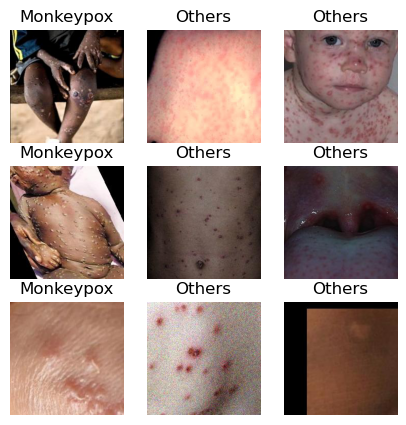

In [11]:
dls = ImageDataLoaders.from_folder(
    path=msld/'Augmented',
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
dls.show_batch(max_n=9, show=True, figsize=(5,5))

In [12]:
# learn = vision_learner(
#     dls=dls,
#     arch=densenet201,
#     loss_func=CrossEntropyLossFlat(),
#     metrics=[Recall(), Precision(), accuracy, F1Score()],
#     pretrained=True
# )

In [ ]:
# from utils import run_experiment
# learn = run_experiment(resnet18, dls=dls, freeze_epochs=1, n_epoch=3, lr=1e-3, bs=32, suggested_lr='minimum', save_records=True)

## Explore hyperparameters

### Finetuning

In [14]:
# learn = run_experiment(densenet169, freeze_epochs=1, n_epoch=2, lr=1e-3,bs=32, dls=dls, suggested_lr='valley', save_model_weights=False)

Running experiment 1/2: bs=64; lr=1.0e-03


epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.634953,0.266691,0.897222,0.920228,0.898119,0.908579,00:13


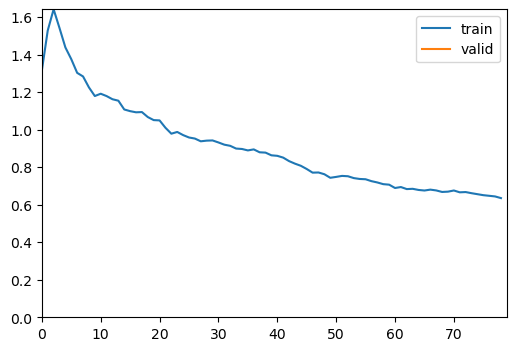

epoch,train_loss,valid_loss,recall_score,precision_score,accuracy,f1_score,time
0,0.268569,0.143118,0.963889,0.940379,0.945141,0.951989,00:19
1,0.188862,0.112943,0.972222,0.953678,0.957680,0.962861,00:19
2,0.143206,0.105526,0.975000,0.966942,0.967085,0.970954,00:17
3,0.101799,0.111322,0.977778,0.956522,0.962382,0.967033,00:20
4,0.065674,0.106020,0.988889,0.959569,0.970219,0.974008,00:21
5,0.053126,0.106349,0.977778,0.969697,0.970219,0.973721,00:19
6,0.042115,0.134023,0.980556,0.956640,0.963950,0.968450,00:19
7,0.049222,0.090858,0.977778,0.975069,0.973354,0.976422,00:21
8,0.028850,0.097814,0.983333,0.969863,0.973354,0.976552,00:21
9,0.037186,0.126334,0.986111,0.951743,0.963950,0.968622,00:20


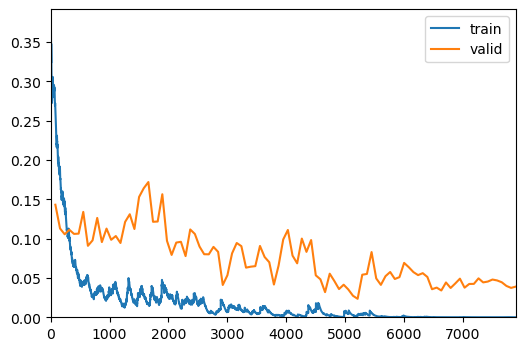

Model saved in densenet169_100_64_1.0e-03_msld-v1_fc22a3ac-15c0-4a48-8bab-3a1397ddcb3c.pth


AttributeError: 'float' object has no attribute 'item'

In [ ]:
freeze_epochs = 1
n_epoch = 100
SAVE_RECORDS = True
# SAVE_RECORDS  = False

hyperparams = (
    # (1e-3, 32),
    # (1e-3,16),
    (1e-3,64),
    (1e-4,32)
)
stats = []

for i, (lr, bs) in enumerate(hyperparams):
    print(f"Running experiment {i+1}/{len(hyperparams)}: bs={bs}; lr={lr:<.1e}")
    learn = run_experiment(
        densenet169,
        dls=dls,
        freeze_epochs=freeze_epochs, 
        n_epoch=n_epoch, 
        lr=lr, 
        bs=bs, 
        save_records=SAVE_RECORDS)
    metrics = {m.name: m.value.item() for m in learn.recorder.metrics}
    pprint(metrics)
    stats.append(metrics)
    print(f"{'-'*40}\n")

### Validation

In [ ]:
dls_test = ImageDataLoaders.from_folder(data / 'MSID-binary', valid_pct=0.90, item_tfms=Resize(224))

In [ ]:
saved_models = [p for p in saved.glob('*.pth')]
[p.stem for p in saved_models]

In [ ]:
learn = vision_learner(
    dls_test,
    resnet18,
    loss_func=CrossEntropyLossFlat(),
    metrics=[Recall(), Precision(), accuracy, F1Score()]
)

validation_results = {}
for m in saved_models:
    print(f"Validating data with model {m.stem}")
    load_model(file=saved_models[0], model=learn.model,opt=learn.opt, with_opt=False)
    res = learn.validate()
    validation_results[m.stem] = res
    pprint(validation_results)
    

In [ ]:
import pandas as pd
results_df = pd.DataFrame(validation_results, ).T
results_df.columns = ['val_loss']+[m.name for m in learn.recorder.metrics]
results_df

In [ ]:
# val_images = get_image_files(data/'MSID-binary')
# print(len(val_images))
# test_dl = learn.dls.test_dl(val_images, bs=64, after_item=[Resize(224)], shuffle=False)